# Credit Card Approval Prediction

https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

In [2]:
# preprocessing
import pandas as pd
import numpy as np

# missing value chart
import missingno

# graph
import matplotlib.pyplot as plt
import seaborn as sns

# sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### For ML

# Tool - sklearn 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Modes
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore') 

SEED = 22

In [3]:
base = pd.read_csv("data/application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("data/credit_record.csv", encoding = 'utf-8')

In [4]:
base.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
base.shape

(438557, 18)

In [6]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [7]:
record.shape

(1048575, 3)

# Create Target

record table의 정보를 통해서 어떤 이용자가 신용이 불량한지 확인하고,
이를 통해 훈련에 사용할 Target데이터를 완성

record table - 속성정보

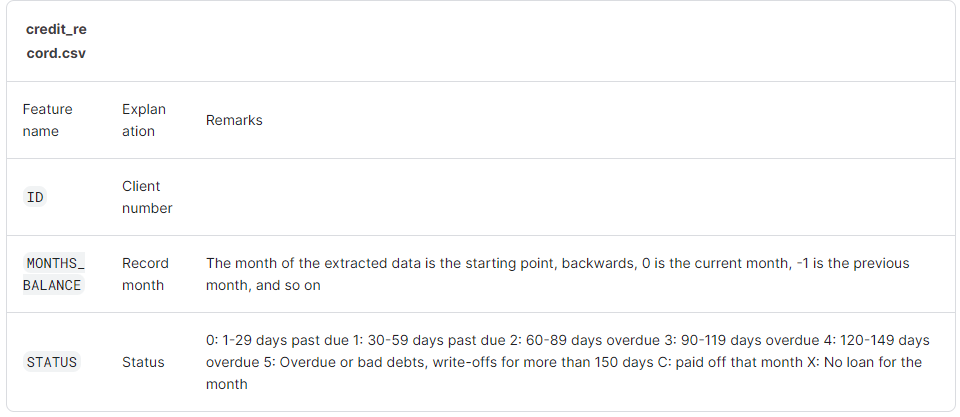

status를 통해서 신용상태를 확인

0 / 1 / 2 / 3 / 4 / 5

In [8]:
record['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

In [9]:
record.head(20)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [10]:
record['ID'].nunique()

45985

In [11]:
status_list = ['0', '1', '2', '3', '4', '5', 'C', 'X']

record_count = pd.DataFrame(record[['ID']])


for stat in status_list:
    temp = record[record['STATUS'] == stat].groupby('ID').count()
    
    temp = temp.drop(columns = 'MONTHS_BALANCE')
    temp = temp.rename(columns={'STATUS' : f'status{stat}'})
    

    record_count = record_count.merge(temp,
                                on = 'ID',
                                how = 'left',
                                suffixes= ('',stat))

record_count = record_count.fillna(0)
record_count.drop_duplicates(inplace=True)
record_count.reset_index(drop = True, inplace = True)
record_count

,ID,status0,status1,status2,status3,status4,status5,statusC,statusX
0,5001711,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5001712,10.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2,5001713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,5001714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,5001715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
...,...,...,...,...,...,...,...,...,...
45980,5150482,12.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
45981,5150483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
45982,5150484,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45983,5150485,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
record_count['total_status'] = record_count.sum(axis=1) - record_count['ID']

record_count.head()

,ID,status0,status1,status2,status3,status4,status5,statusC,statusX,total_status
0,5001711,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
1,5001712,10.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,19.0
2,5001713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0
3,5001714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0
4,5001715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,60.0


In [13]:
record_count['ID'].nunique()

45985

In [14]:
### 신용카드 연체일 별 연체자 수

record_count['overdue'] = record_count[['status0', 'status1', 'status2', 'status3', 'status4', 'status5']].apply(lambda x: 1 if any(x != 0) else 0, axis=1)
record_count['over30'] = record_count[['status1', 'status2', 'status3', 'status4', 'status5']].apply(lambda x: 1 if any(x != 0) else 0, axis=1)
record_count['over60'] = record_count[['status2', 'status3', 'status4', 'status5']].apply(lambda x: 1 if any(x != 0) else 0, axis=1)
record_count['over90'] = record_count[['status3', 'status4', 'status5']].apply(lambda x: 1 if any(x != 0) else 0, axis=1)

print('1일 이상 연체 발생자 :' , record_count['overdue'].sum())
print('30일 이상 연체 발생자 :' , record_count['over30'].sum())
print('60일 이상 연체 발생자 :' , record_count['over60'].sum())
print('90일 이상 연체 발생자 :' , record_count['over90'].sum())

1일 이상 연체 발생자 : 40032
30일 이상 연체 발생자 : 5350
60일 이상 연체 발생자 : 667
90일 이상 연체 발생자 : 331


In [15]:
#### 신용카드 연체일 별 연체자 수 
## 신용카드 연체 기준은 90일 / 하지만 90일을 선택할 경우 imbalaced data
## 연습을 위해 30일을 기준으로 선택

record_count.head(10)

,ID,status0,status1,status2,status3,status4,status5,statusC,statusX,total_status,overdue,over30,over60,over90
0,5001711,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1,0,0,0
1,5001712,10.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,19.0,1,0,0,0
2,5001713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0,0,0,0,0
3,5001714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0,0,0,0
4,5001715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,60.0,0,0,0,0
5,5001717,17.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,22.0,1,0,0,0
6,5001718,24.0,2.0,0.0,0.0,0.0,0.0,3.0,10.0,39.0,1,1,0,0
7,5001719,2.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,43.0,1,0,0,0
8,5001720,29.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,1,1,0,0
9,5001723,8.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,31.0,1,0,0,0


In [16]:
df_target = record_count[['ID', 'overdue', 'over30', 'over60', 'over90']]
df_target.head()

,ID,overdue,over30,over60,over90
0,5001711,1,0,0,0
1,5001712,1,0,0,0
2,5001713,0,0,0,0
3,5001714,0,0,0,0
4,5001715,0,0,0,0


In [17]:
df_target.over30.value_counts(())

over30
0    40635
1     5350
Name: count, dtype: int64

In [18]:
df_target['ID']

0        5001711
1        5001712
2        5001713
3        5001714
4        5001715
          ...   
45980    5150482
45981    5150483
45982    5150484
45983    5150485
45984    5150487
Name: ID, Length: 45985, dtype: int64

## base + record 

두개의 데이터 프레임 결합

In [19]:
base.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [20]:
df = pd.merge(base, df_target, how = 'inner', on = 'ID')
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,overdue,over30,over60,over90
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,1,1,0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,1,1,0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,1,0,0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,1,0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,0,0,0,0


In [21]:
print('base ID 수:' , base['ID'].nunique())
print('record ID 수:' , record_count['ID'].nunique())
print('merged ID 수:' , df['ID'].nunique())

base ID 수: 438510
record ID 수: 45985
merged ID 수: 36457


## 데이터 전처리

In [22]:
df = df.rename(columns={
    'CODE_GENDER':'gender',
    'FLAG_OWN_CAR':'own_car',
    'FLAG_OWN_REALTY':'own_house',
    'CNT_CHILDREN':'children',
    'AMT_INCOME_TOTAL':'inc',
    'NAME_INCOME_TYPE':'employment',
    'NAME_EDUCATION_TYPE':'edu',
    'NAME_FAMILY_STATUS':'marry',
    'NAME_HOUSING_TYPE':'house_type',
    'DAYS_BIRTH':'age',
    'DAYS_EMPLOYED': 'employ_length',
    'FLAG_MOBIL': 'own_mobile',
    'FLAG_WORK_PHONE': 'own_workphone',
    'FLAG_PHONE': 'own_phone',
    'FLAG_EMAIL': 'own_email',
    'OCCUPATION_TYPE': 'job',
    'CNT_FAM_MEMBERS': 'family'
    })

In [23]:
df.head(5)

,ID,gender,own_car,own_house,children,inc,employment,edu,marry,house_type,...,own_mobile,own_workphone,own_phone,own_email,job,family,overdue,over30,over60,over90
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,1,1,0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,1,1,0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,1,0,0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,1,0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,0,0,0,0


In [24]:
df.shape

(36457, 22)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             36457 non-null  int64  
 1   gender         36457 non-null  object 
 2   own_car        36457 non-null  object 
 3   own_house      36457 non-null  object 
 4   children       36457 non-null  int64  
 5   inc            36457 non-null  float64
 6   employment     36457 non-null  object 
 7   edu            36457 non-null  object 
 8   marry          36457 non-null  object 
 9   house_type     36457 non-null  object 
 10  age            36457 non-null  int64  
 11  employ_length  36457 non-null  int64  
 12  own_mobile     36457 non-null  int64  
 13  own_workphone  36457 non-null  int64  
 14  own_phone      36457 non-null  int64  
 15  own_email      36457 non-null  int64  
 16  job            25134 non-null  object 
 17  family         36457 non-null  float64
 18  overdu

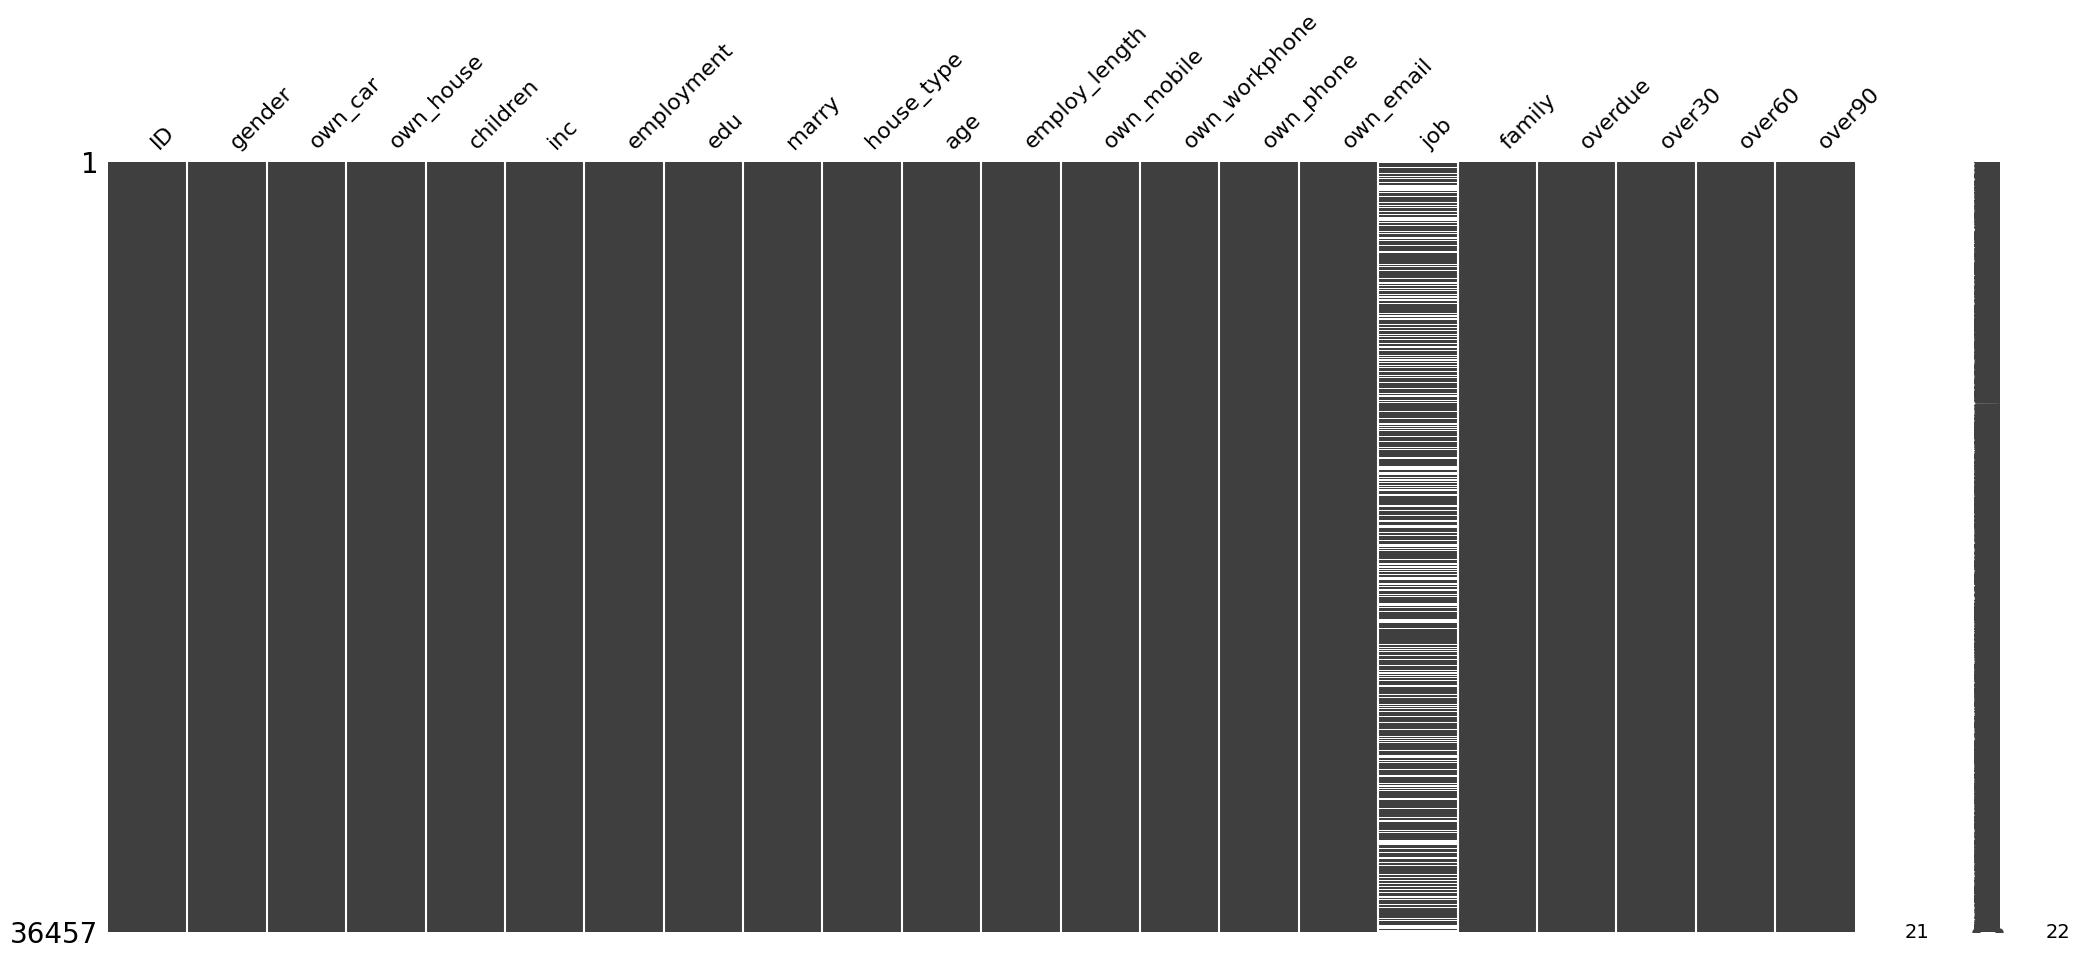

In [26]:
missingno.matrix(df)
plt.show()
## job feature 에만 NA존재

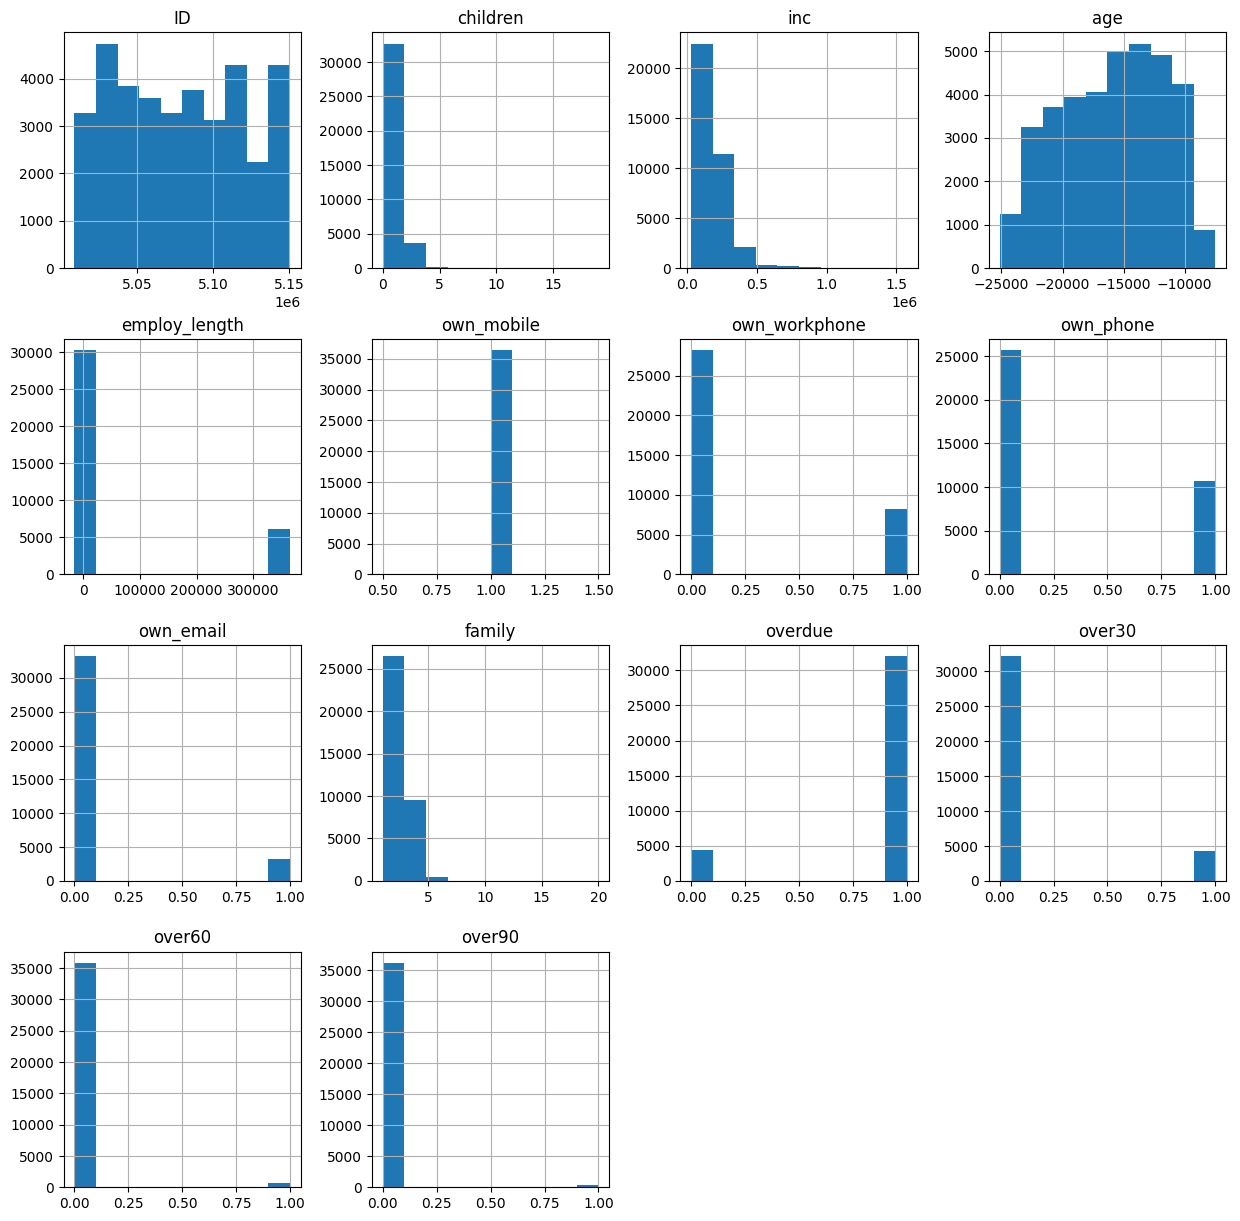

In [27]:
# 전체 feature -> plot

plt.rc('axes', labelsize=14, titlesize=12)
plt.rc('legend', fontsize=14)

df.hist(figsize=(15, 15))
plt.savefig('image/numric.png')
plt.show()

In [28]:
# 변수의 형태별로 플롯을 다시 그리기 위해 
# 각각의 feature를 구분

binominal_val = ['gender', 'own_car', 'own_house',  'own_mobile', 'own_workphone', 'own_phone', 'own_email', ]
cateorical_val = ['edu', 'marry', 'house_type', 'job',  'employment']
numeric_val = ['age', 'employ_length', 'family', 'inc',  'children']


In [29]:
len(binominal_val) +  len(cateorical_val) + len(numeric_val)

17

In [30]:
len(df.columns)

22

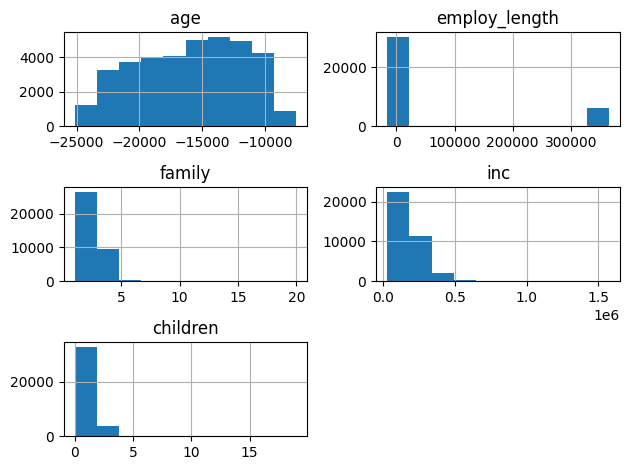

In [31]:
### numeric feature_origin
plt.rc('axes', labelsize=14, titlesize=12)
plt.rc('legend', fontsize=14)

df[numeric_val].hist()

plt.tight_layout()
plt.title('numeric_val')
plt.savefig('image/feature_plot/numeric_origin.png')
#plt.show()


### Numeric Feature preprocessing

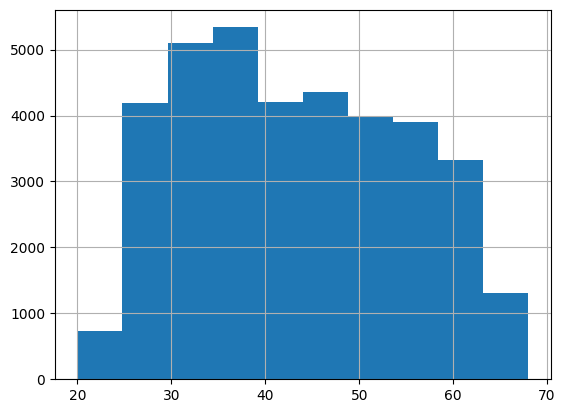

In [32]:
# age - Birthday	Count backwards from current day (0), -1 means yesterday

# age를 절대값으로 바꾸고, 연나이로 바꾸고
#  floor 함수 적용
df['age'] = df['age'].apply(lambda x : np.floor(abs(x) / 365))
df['age'].hist()
plt.show()

In [33]:
# employ_length - Count backwards from current day(0). If positive, it means the person currently unemployed.

df['employ_length'].value_counts()

employ_length
 365243    6135
-401         78
-1539        64
-200         63
-1678        61
           ... 
-4686         1
-2160         1
-2007         1
-758          1
-11272        1
Name: count, Length: 3640, dtype: int64

1.763642389842931


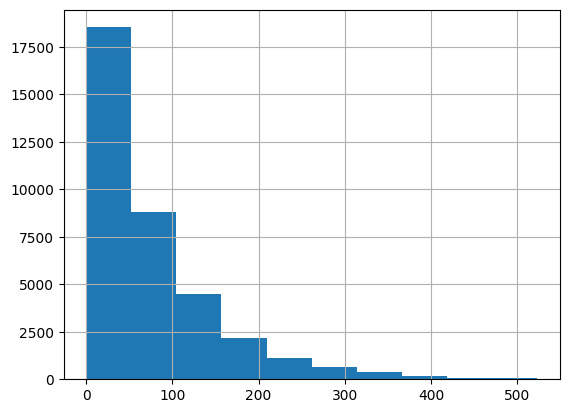

In [34]:
df['employ_length'] = df['employ_length'].apply(lambda x: np.floor(abs(x) / 30) if x < 0 else 0)
print(df['employ_length'].skew())
df['employ_length'].hist()
plt.show()

<Axes: >

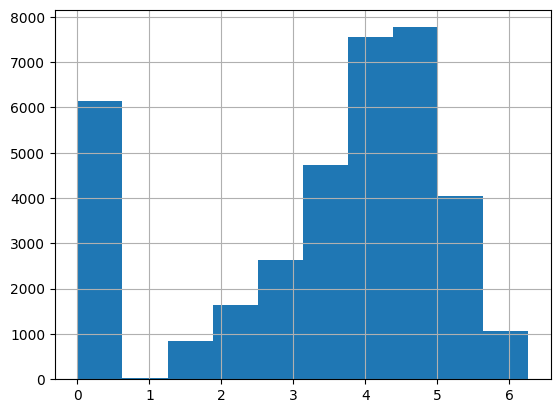

In [35]:
# skewness를 해결하기 위해서 log변환

df['employ_length'] = df['employ_length'].apply(lambda x: np.log(x + 1))
df['employ_length'].hist()

In [36]:
## children

df['children'].value_counts()

children
0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: count, dtype: int64

In [37]:
## 3이상인 경우 

print(df[df['children'] >= 3].shape[0])
print(f"자녀수가 3이상인 경우는 전체의 {round((df[df['children'] >= 3].shape[0]) / df.shape[0] * 100, 2)}%")

508
자녀수가 3이상인 경우는 전체의 1.39%


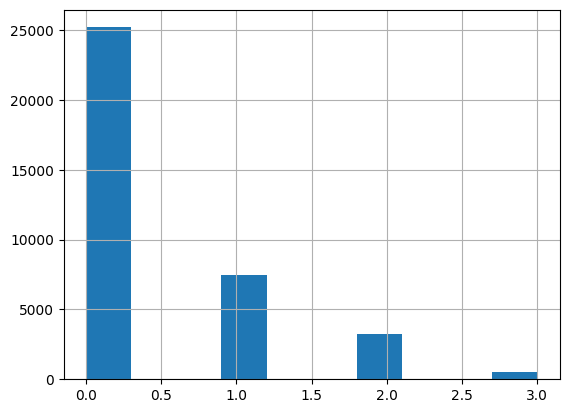

In [38]:
# 3이상을 하나의 카테고리로 변환

df['children'] = df['children'].apply(lambda x: x if x < 3 else 3)
df['children'].hist()
plt.show()

In [39]:
# family

df['family'].value_counts()

family
2.0     19463
1.0      6987
3.0      6421
4.0      3106
5.0       397
6.0        58
7.0        19
15.0        3
9.0         2
20.0        1
Name: count, dtype: int64

In [40]:
## 5이상인 경우 

print(df[df['family'] >= 5].shape[0])
print(f"자녀수가 5이상인 경우는 전체의 {round((df[df['family'] >= 5].shape[0]) / df.shape[0] * 100, 2)}%")

480
자녀수가 5이상인 경우는 전체의 1.32%


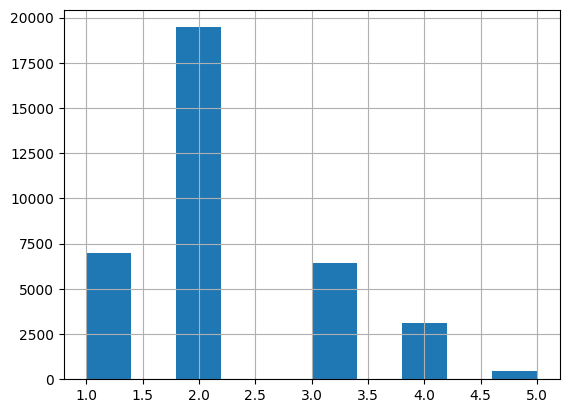

In [41]:
# 5이상을 하나의 카테고리로 변환

df['family'] = df['family'].apply(lambda x: x if x < 5 else 5)
df['family'].hist()
plt.show()

In [42]:
# inc
print(df['inc'].describe())
print(df['inc'].skew())



count    3.645700e+04
mean     1.866857e+05
std      1.017892e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: inc, dtype: float64
2.739009876253129


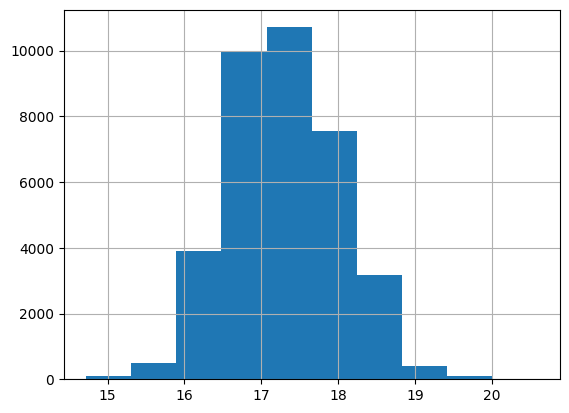

In [43]:
# inc_log 변환

df['inc'] = np.log2(df['inc'])
df['inc'].hist()
plt.show()

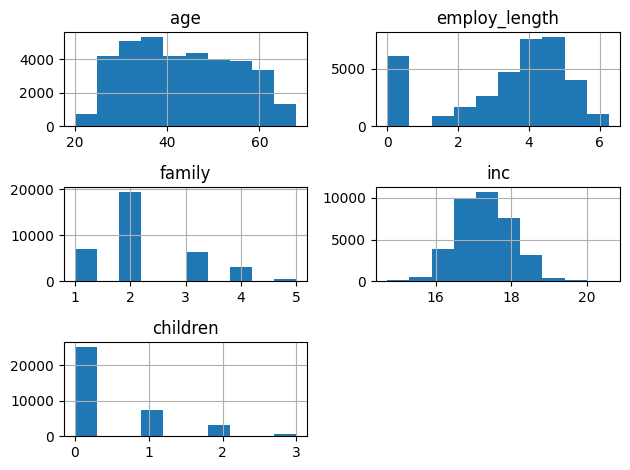

In [44]:
### numeric feature _ after preprocessing
plt.rc('axes', labelsize=14, titlesize=12)
plt.rc('legend', fontsize=14)

df[numeric_val].hist()

plt.tight_layout()
plt.title('numeric_val')
plt.savefig('image/feature_plot/numeric.png')
#plt.show()

In [45]:
### non-numeric feature

binominal_val = ['gender', 'own_car', 'own_house',  'own_mobile', 'own_workphone', 'own_phone', 'own_email', ]
cateorical_val = ['edu', 'marry', 'house_type', 'job',  'employment']

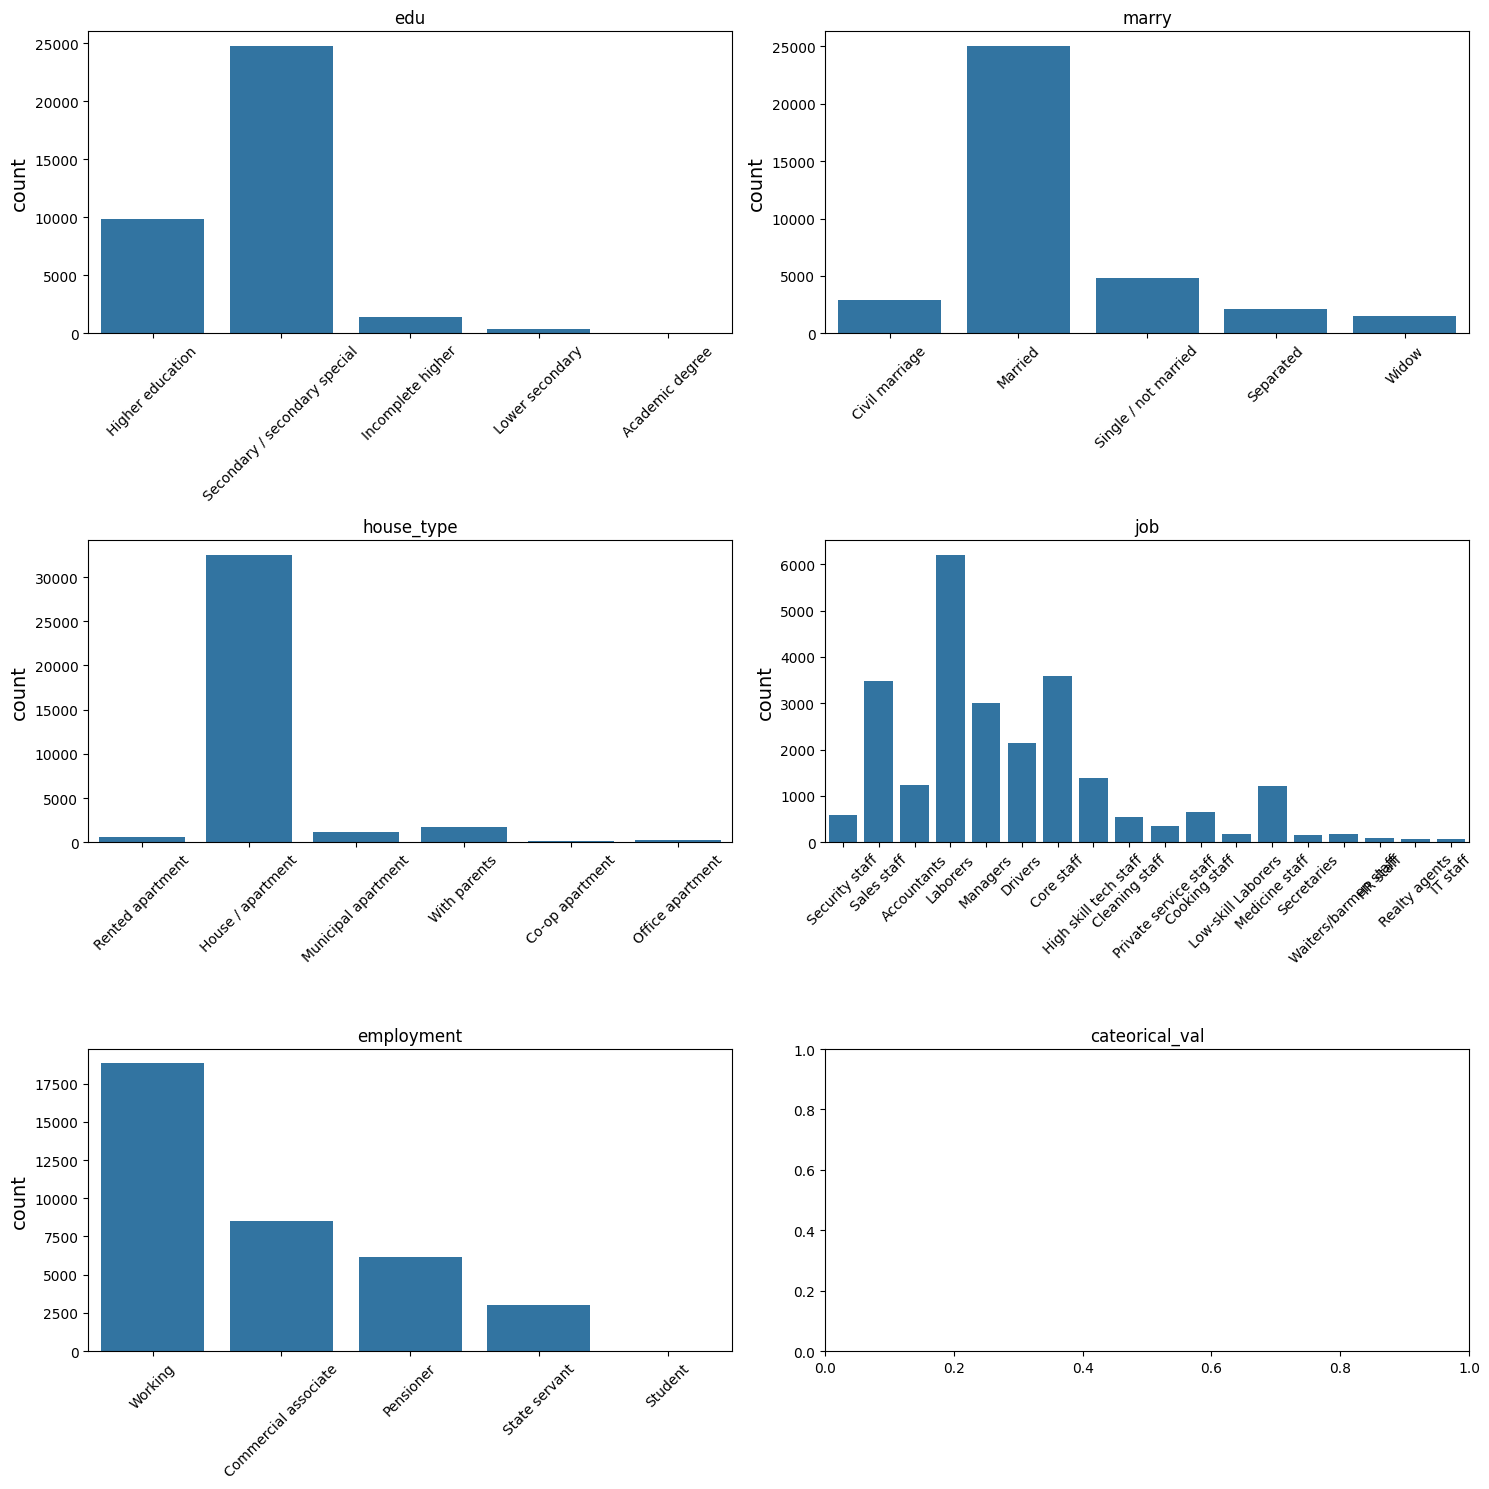

In [46]:
# categorical feature
f, axes = plt.subplots(3, 2, figsize=(15, 15))

for i, column in enumerate(cateorical_val):
    sns.countplot(data=df, x=column, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(column)  # 각 subplot에 제목 설정
    axes[i//2, i%2].set_xlabel('')
    axes[i//2, i%2].tick_params(axis='x', rotation=45)  # x축 눈금 회전

plt.title('cateorical_val')
plt.tight_layout()  # 서브플롯 간의 간격 조정
plt.savefig('image/feature_plot/category.png')
#plt.show()

In [47]:
## categorical feature 이름 바꾸기?
# onehot encoding시 value -> 변수명으로
# 나중에 해석이 어려울듯 하여 라벨을 변경하지 않음

# # 교육 수준에 따라 새로운 라벨 정의
# edu_level = {
#     'Lower secondary': 0,
#     'Secondary / secondary special': 1,
#     'Incomplete higher': 2,
#     'Higher education': 3,
#     'Academic degree': 4
# }

# # 'education' 열의 라벨을 새로운 라벨로 변경
# df['edu'].map(edu_level)

# # 가족 형태에 따라 새로운 라벨 정의
# marry_level = {
#     'Married': 0,
#     'Single / not married': 1,
#     'Civil marriage': 2,        
#     'Separated': 3,
#     'Widow': 4
# }

# # 'family_status' 열의 라벨을 새로운 라벨로 변경
# df['marry'] = df['marry'].map(marry_level)

# house_level = {
#     'Rented apartment': 0,
#     'House / apartment': 1,
#     'Municipal apartment': 2,
#     'With parents': 3,
#     'Co-op apartment': 4,
#     'Office apartment': 5
# }

# # 'housing_type' 열의 라벨을 새로운 라벨로 변경
# df['house_type'] = df['house_type'].map(house_level)

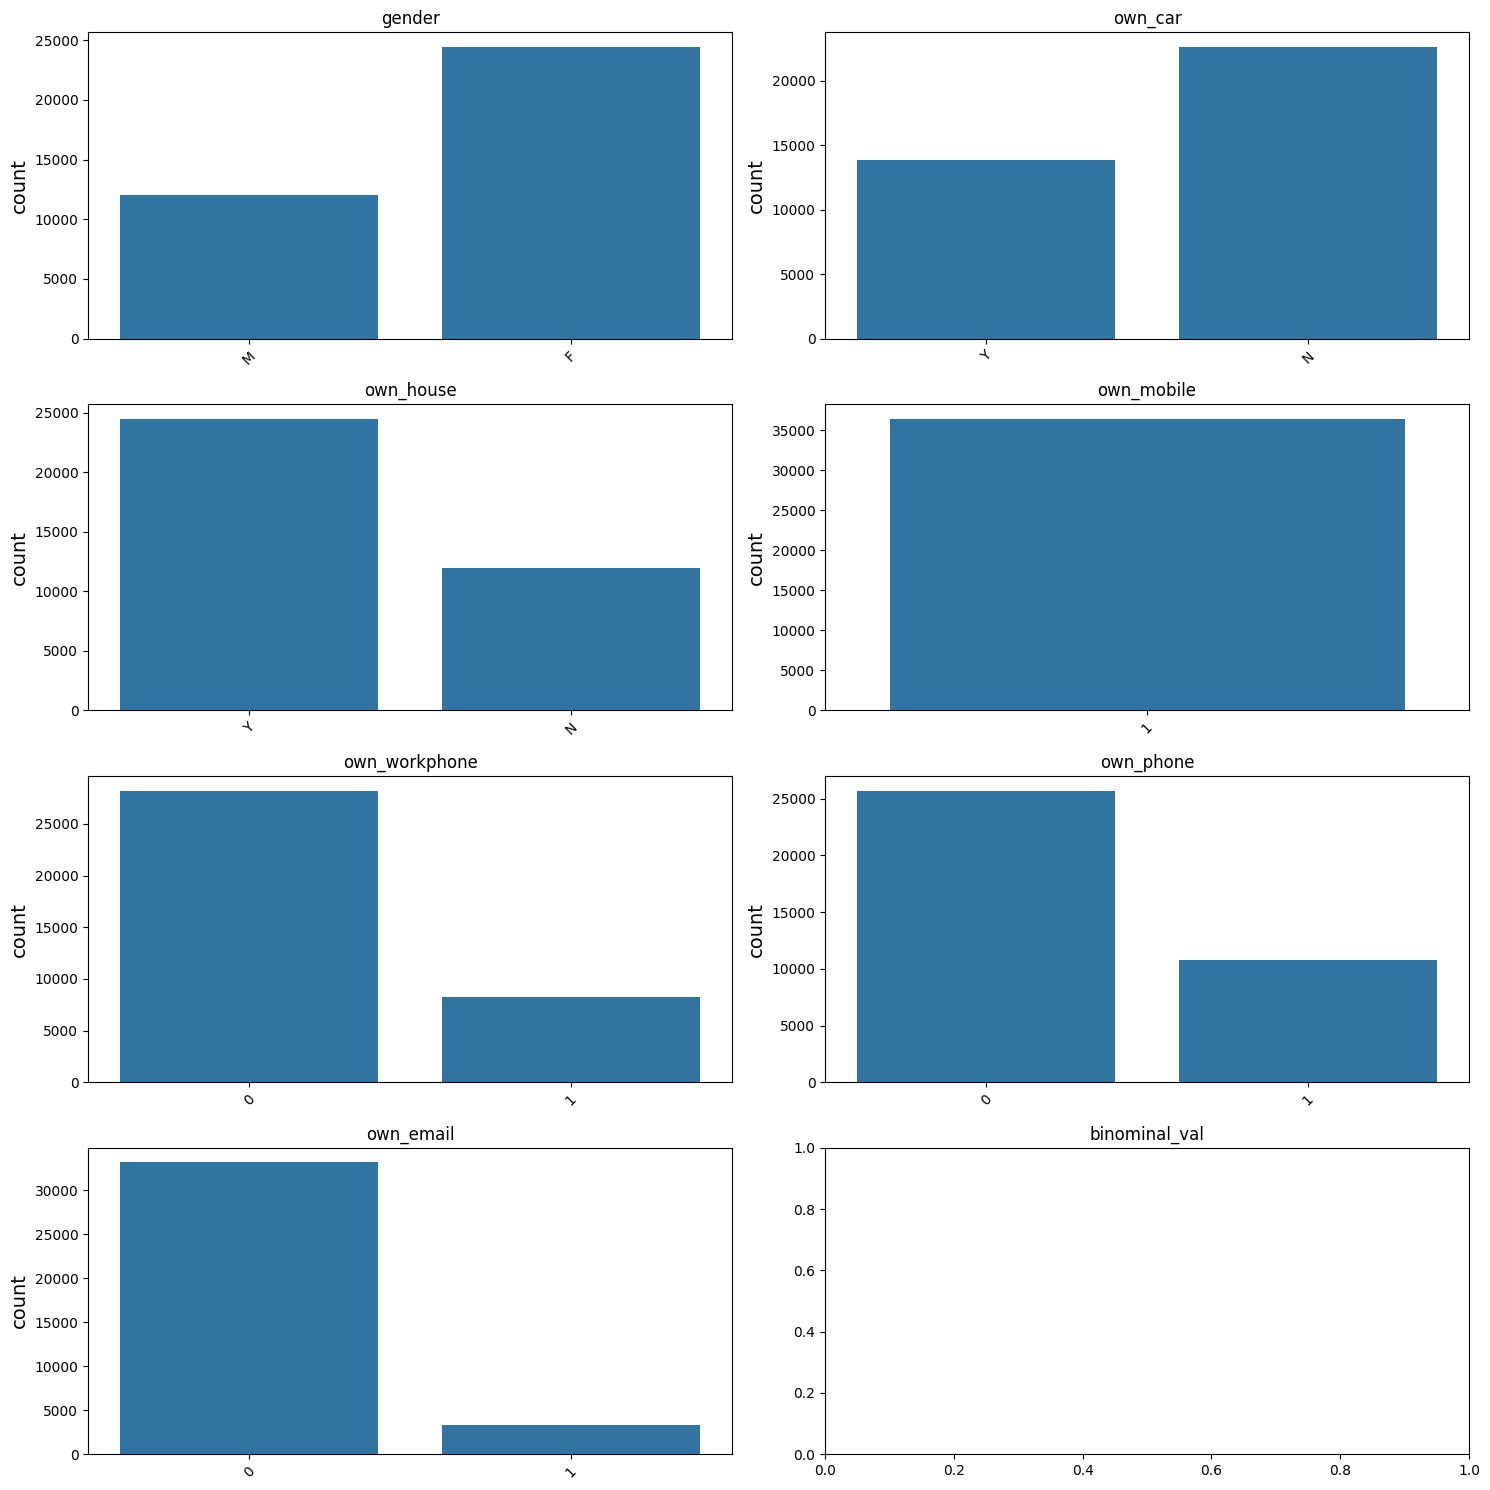

In [48]:
# binominal feature

f, axes = plt.subplots(4, 2, figsize=(15, 15))

for i, column in enumerate(binominal_val):
    sns.countplot(data=df, x=column, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(column)  # 각 subplot에 제목 설정
    axes[i//2, i%2].set_xlabel('')
    axes[i//2, i%2].tick_params(axis='x', rotation=45)  # x축 눈금 회전

plt.title('binominal_val')
plt.tight_layout()  # 서브플롯 간의 간격 조정
plt.savefig('image/feature_plot/binominal.png')
#plt.show()

## drop feature

In [49]:
df['own_mobile'].value_counts()
# 전부 휴대폰 소유

own_mobile
1    36457
Name: count, dtype: int64

In [50]:
#  job - na 값 다수 존재
df['job'].isnull().sum()

11323

In [51]:
# own_mobil / job / ID변수 드랍

drop_val = ['own_mobile', 'job', 'ID']

df.drop(columns=drop_val,  inplace=True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         36457 non-null  object 
 1   own_car        36457 non-null  object 
 2   own_house      36457 non-null  object 
 3   children       36457 non-null  int64  
 4   inc            36457 non-null  float64
 5   employment     36457 non-null  object 
 6   edu            36457 non-null  object 
 7   marry          36457 non-null  object 
 8   house_type     36457 non-null  object 
 9   age            36457 non-null  float64
 10  employ_length  36457 non-null  float64
 11  own_workphone  36457 non-null  int64  
 12  own_phone      36457 non-null  int64  
 13  own_email      36457 non-null  int64  
 14  family         36457 non-null  float64
 15  overdue        36457 non-null  int64  
 16  over30         36457 non-null  int64  
 17  over60         36457 non-null  int64  
 18  over90

# onehot encoding

In [53]:
binominal_val = [val for val in binominal_val if val not in drop_val]
cateorical_val = [val for val in cateorical_val if val not in drop_val]

In [54]:
df = pd.get_dummies(df, columns=cateorical_val, dtype='int')
df = pd.get_dummies(df, columns=binominal_val, dtype='int')
df.head()

,children,inc,age,employ_length,family,overdue,over30,over60,over90,edu_Academic degree,...,own_car_N,own_car_Y,own_house_N,own_house_Y,own_workphone_0,own_workphone_1,own_phone_0,own_phone_1,own_email_0,own_email_1
0,0,18.705565,32.0,5.023881,2.0,1,1,0,0,0,...,0,1,0,1,0,1,1,0,1,0
1,0,18.705565,32.0,5.023881,2.0,1,1,0,0,0,...,0,1,0,1,0,1,1,0,1,0
2,0,16.779565,58.0,3.637586,2.0,1,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
3,0,18.042600,52.0,4.624973,1.0,1,0,0,0,0,...,1,0,0,1,1,0,0,1,0,1
4,0,18.042600,52.0,4.624973,1.0,0,0,0,0,0,...,1,0,0,1,1,0,0,1,0,1


# delete outlier

In [55]:
def delete_outlier(df, features):
        
    for column in features:
    
        outlier_list = []

        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)

        # Remove duplicates in the outlier_list
        outlier_list = list(set(outlier_list))

        # Drop outliers
        df.drop(outlier_list, inplace=True)

In [56]:
outlier_feature = set()
outlier_feature.add('employ_length')
outlier_feature.add('inc')
outlier_feature.add('age')

In [57]:
df_out = df.copy()
delete_outlier(df_out, outlier_feature)

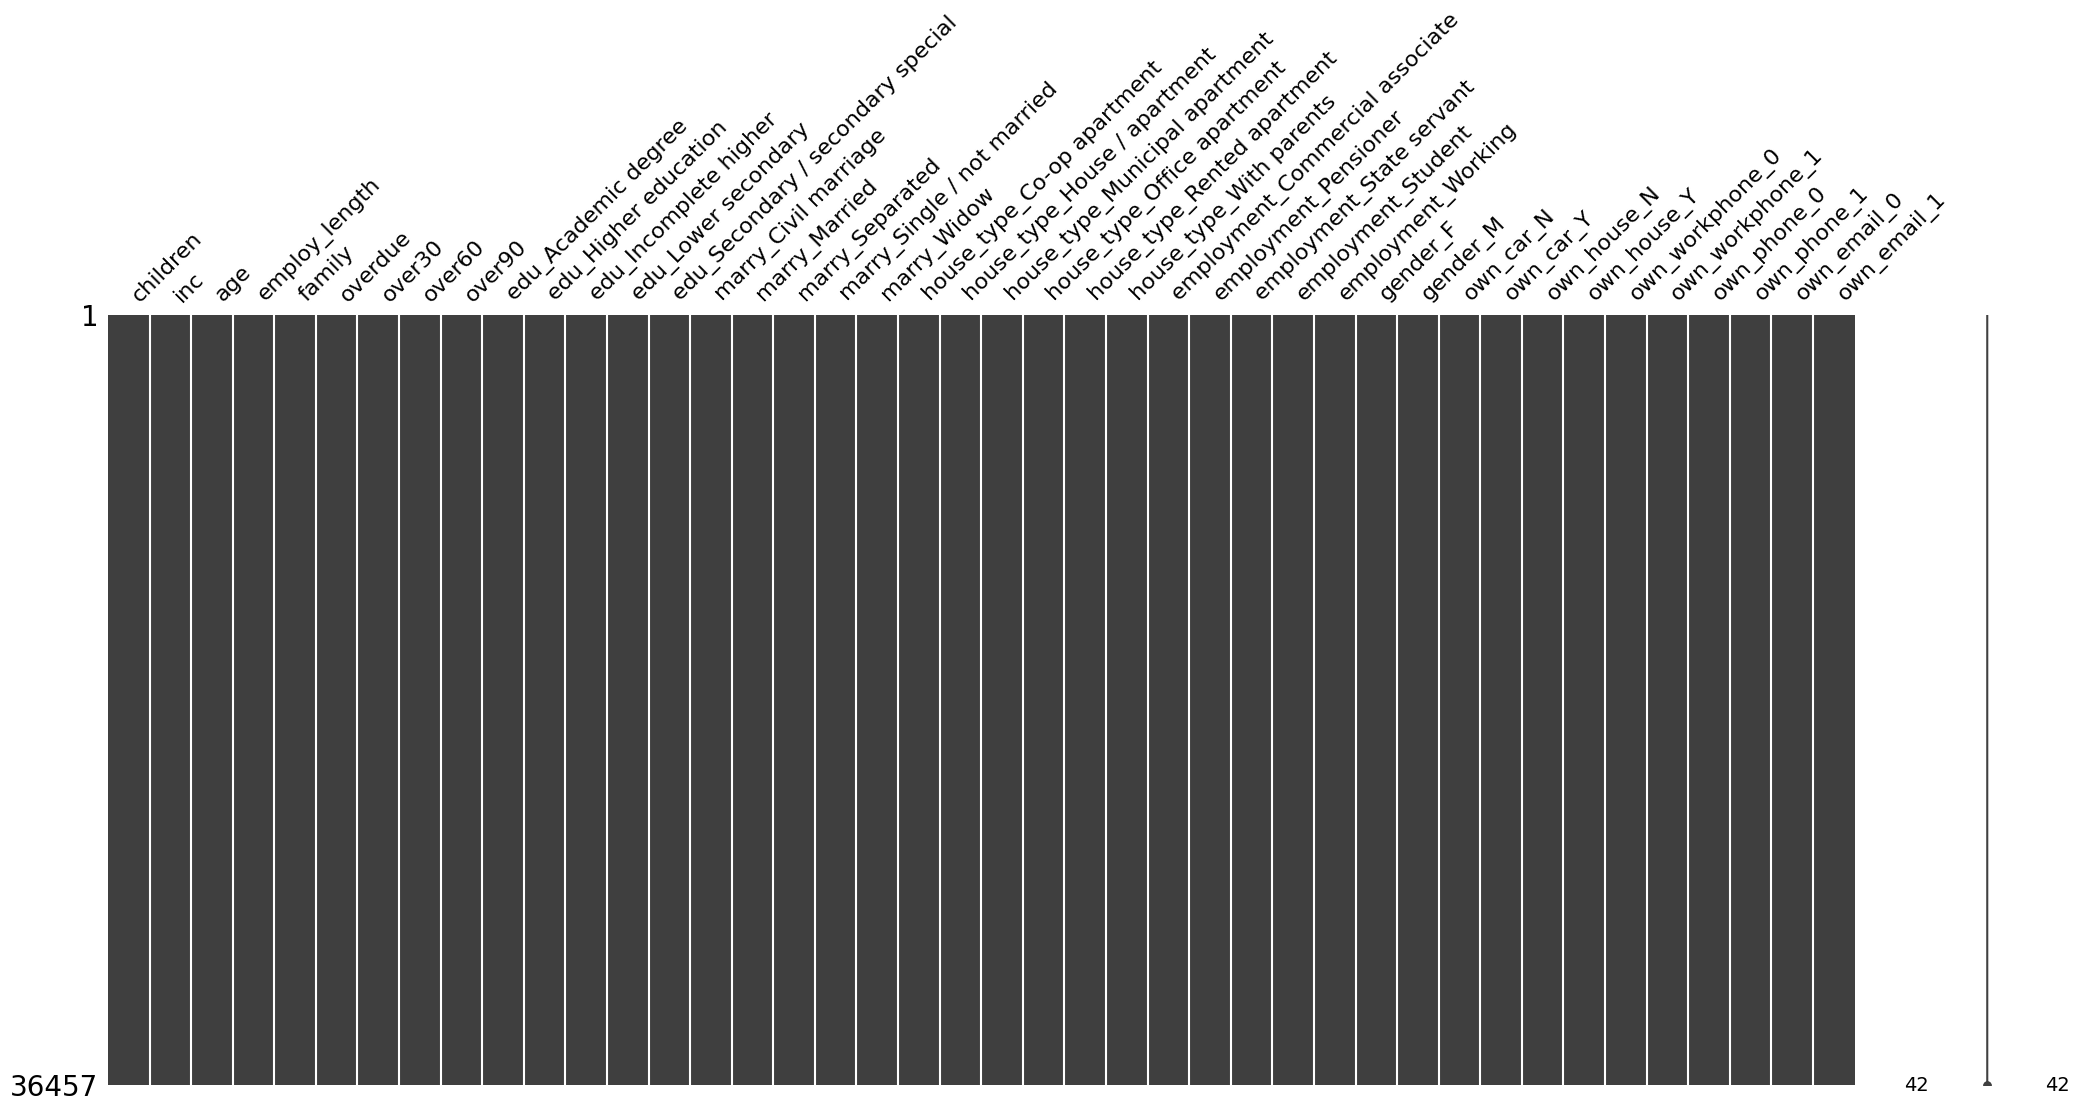

In [58]:
missingno.matrix(df)
plt.show()

In [59]:
df_out.to_csv('data/data.csv', index = False)

### 전처리 결과 테스트 (간단한 모델로)

- 여러 전처리 방식을 비교해서 총 6가지 전처리 방식을 적용
- 간단한 모델의 성능이 좋은 전처리 방식 선정
- outlier.xlsx 참고

In [60]:
df['over30'].value_counts()

over30
0    32166
1     4291
Name: count, dtype: int64

In [61]:
df['over60'].value_counts()

over60
0    35841
1      616
Name: count, dtype: int64

In [62]:
X = df_out.drop(columns=['overdue', 'over30', 'over60', 'over90'])
y = df_out['over90']

In [63]:
from imblearn.over_sampling import SMOTE
sm2 = SMOTE(sampling_strategy=0.1, random_state=SEED)
X, y = sm2.fit_resample(X, y)

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31304, 38), (7826, 38), (31304,), (7826,))

In [65]:
X.columns

Index(['children', 'inc', 'age', 'employ_length', 'family',
       'edu_Academic degree', 'edu_Higher education', 'edu_Incomplete higher',
       'edu_Lower secondary', 'edu_Secondary / secondary special',
       'marry_Civil marriage', 'marry_Married', 'marry_Separated',
       'marry_Single / not married', 'marry_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'employment_Commercial associate', 'employment_Pensioner',
       'employment_State servant', 'employment_Student', 'employment_Working',
       'gender_F', 'gender_M', 'own_car_N', 'own_car_Y', 'own_house_N',
       'own_house_Y', 'own_workphone_0', 'own_workphone_1', 'own_phone_0',
       'own_phone_1', 'own_email_0', 'own_email_1'],
      dtype='object')

In [66]:
# 불균형 데이터임으로 SMOTE를 통해서 balance data로 변환

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state= SEED)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [67]:
X_resampled.shape, len(y_resampled)

((56916, 38), 56916)

In [68]:
y_test.value_counts()

over90
0    7115
1     711
Name: count, dtype: int64

In [69]:
y_train.value_counts()

over90
0    28458
1     2846
Name: count, dtype: int64

In [70]:
y_resampled.value_counts()


over90
0    28458
1    28458
Name: count, dtype: int64

#### logistic

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 로지스틱 회귀 분류기로 파이프라인 구성
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: StandardScaler for feature scaling
    ('lr', LogisticRegression(random_state=SEED))  # Step 2: lr Regression Classifier
])

# 파이프라인을 사용하여 학습
lr_pipe.fit(X_resampled, y_resampled)

# 훈련 정확도 출력
train_score = lr_pipe.score(X_resampled, y_resampled)
print("Training Accuracy:", train_score)

Training Accuracy: 0.8749385058682971


In [72]:
lr_pipe.score(X_test, y_test)

0.962816253513928

In [73]:
y_test.value_counts()

over90
0    7115
1     711
Name: count, dtype: int64

In [74]:
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt


# F1 score 계산
y_pred_train = lr_pipe.predict(X_resampled)
f1_train = f1_score(y_resampled, y_pred_train)
print("Training F1 Score:", f1_train)

y_pred_test = lr_pipe.predict(X_test)
f1_test = f1_score(y_pred_test, y_test)
print("Test F1 Score:", f1_test)

Training F1 Score: 0.8593336231769495
Test F1 Score: 0.7783701447067783


##### XGBoost

In [75]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: StandardScaler for feature scaling
    ('xgb', XGBClassifier(random_state=SEED))  # Step 2: XGBoost Classifier
])

xgb_pipe.fit(X_resampled, y_resampled)
train_score = xgb_pipe.score(X_resampled, y_resampled)
print("Training Accuracy:", train_score)

Training Accuracy: 0.9953440157424978


In [76]:
xgb_pipe.score(X_test, y_test)

0.9901610017889088

In [77]:
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt


# F1 score 계산
y_pred_train = xgb_pipe.predict(X_resampled)
f1_train = f1_score(y_resampled, y_pred_train)
print("Training F1 Score:", f1_train)

y_pred_test = xgb_pipe.predict(X_test)
f1_test = f1_score(y_pred_test, y_test)
print("Test F1 Score:", f1_test)



Training F1 Score: 0.9953473673121829
Test F1 Score: 0.9461161651504548


In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Random Forest 분류기로 파이프라인 구성
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: StandardScaler for feature scaling
    ('rf', RandomForestClassifier(random_state=SEED))  # Step 2: Random Forest Classifier
])

# 파이프라인을 사용하여 학습
rf_pipe.fit(X_resampled, y_resampled)

# 훈련 정확도 출력
train_score = rf_pipe.score(X_resampled, y_resampled)
print("Training Accuracy:", train_score)

Training Accuracy: 0.9962927823459132


In [79]:
rf_pipe.score(X_test, y_test)

0.9897776641962689

In [80]:
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt


# F1 score 계산
y_pred_train = rf_pipe.predict(X_resampled)
f1_train = f1_score(y_resampled, y_pred_train)
print("Training F1 Score:", f1_train)

y_pred_test = rf_pipe.predict(X_test)
f1_test = f1_score(y_pred_test, y_test)
print("Test F1 Score:", f1_test)


Training F1 Score: 0.9962976610341984
Test F1 Score: 0.9438990182328191
